# Distinción de velocidades segun hora

En este codigo distinguira las velocidades segun la hora

## Necesarios
* Librerias instaladas en especial Geopandas
* Velocidades calibradas

In [1]:
# Tratamiento de datos
# ==============================================================================
import gpxpy 
import gpxpy.gpx
import pandas as pd
import numpy as np
import geopandas as gp

# Gráficos
# ==============================================================================
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns

# Preprocesado y modelado
# ==============================================================================
from scipy.stats import pearsonr
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm
import statsmodels.formula.api as smf
from datetime import datetime, time, date
from os import listdir
import os
import re
from shapely.geometry import Point, LineString
from shapely import wkt

# Configuración matplotlib
# ==============================================================================
plt.rcParams['image.cmap'] = "bwr"
#plt.rcParams['figure.dpi'] = "100"
plt.rcParams['savefig.bbox'] = "tight"
style.use('ggplot') or plt.style.use('ggplot')
sns.set_theme(style="whitegrid")

# Configuración warnings
# ==============================================================================
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.float_format', lambda x: '%.5f' % x)

In [2]:
#Se cargan los puntos de velocidad que se usaran
velocidades = gp.read_file("G:/Mi unidad/Docencia/Maestria UNAL/Trabajo de grado/Tesis 2.0/Tesis/VelocidadesPMMEP/shapes_fin/Carro.shp")
velocidadesm = gp.read_file("G:/Mi unidad/Docencia/Maestria UNAL/Trabajo de grado/Tesis 2.0/Tesis/VelocidadesPMMEP/shapes_fin/Moto.shp")
velocidadesb = gp.read_file("G:/Mi unidad/Docencia/Maestria UNAL/Trabajo de grado/Tesis 2.0/Tesis/VelocidadesPMMEP/shapes_fin/Bici.shp")
velocidadest = gp.read_file("G:/Mi unidad/Docencia/Maestria UNAL/Trabajo de grado/Tesis 2.0/Tesis/VelocidadesPMMEP/shapes_fin/TPC.shp")

In [3]:
#Segun la columna de tiempo calcula el entero de segundos definiendo una funcion
def time_to_num(time_str):
    hh, mm , ss = map(int, time_str.split(':'))
    return ss + 60*(mm + 60*hh)

## TPC

In [4]:
#calcular los segundos a partir de la función definida
velocidadest['sec'] = velocidadest.apply(
    lambda row: time_to_num(
        time_str=row['tiempo']
    ),
    axis=1
)

In [5]:
#Se visualiza los datos para ver el calculo
velocidadest.head(6)

,file,ID,altura,velocity_m,velocity_k,timestamp,latitud,longitud,tiempo,angulo_vel,geometry,sec
0,1,1,1324.00000,5.55556,20.00000,2017-06-16 09:11:55,4.45272,-75.24493,09:11:55,307.39506,POINT (870423.510 984235.894),33115
1,1,2,1325.00000,5.00000,18.00000,2017-06-16 09:12:02,4.45293,-75.24522,09:12:02,201.45898,POINT (870392.095 984259.908),33122
2,1,3,1331.00000,5.00000,18.00000,2017-06-16 09:12:25,4.45195,-75.24560,09:12:25,192.94028,POINT (870349.370 984151.215),33145
3,1,4,1333.00000,4.44444,16.00000,2017-06-16 09:12:33,4.45158,-75.24568,09:12:33,126.86010,POINT (870340.055 984110.675),33153
4,1,5,1333.00000,8.33333,30.00000,2017-06-16 09:12:37,4.45148,-75.24555,09:12:37,119.16920,POINT (870354.838 984099.591),33157
5,1,6,1329.00000,5.55556,20.00000,2017-06-16 09:12:48,4.45108,-75.24483,09:12:48,119.98164,POINT (870434.325 984055.224),33168


In [6]:
#Se calculan los datos de minutos y segundos 
velocidadest["min"] = (velocidadest["sec"] /60)
velocidadest["hr"] = (velocidadest["min"] /60)

In [7]:
#Se visualiza la tabla para chequear valores
velocidadest

,file,ID,altura,velocity_m,velocity_k,timestamp,latitud,longitud,tiempo,angulo_vel,geometry,sec,min,hr
0,1,1,1324.00000,5.55556,20.00000,2017-06-16 09:11:55,4.45272,-75.24493,09:11:55,307.39506,POINT (870423.510 984235.894),33115,551.91667,9.19861
1,1,2,1325.00000,5.00000,18.00000,2017-06-16 09:12:02,4.45293,-75.24522,09:12:02,201.45898,POINT (870392.095 984259.908),33122,552.03333,9.20056
2,1,3,1331.00000,5.00000,18.00000,2017-06-16 09:12:25,4.45195,-75.24560,09:12:25,192.94028,POINT (870349.370 984151.215),33145,552.41667,9.20694
3,1,4,1333.00000,4.44444,16.00000,2017-06-16 09:12:33,4.45158,-75.24568,09:12:33,126.86010,POINT (870340.055 984110.675),33153,552.55000,9.20917
4,1,5,1333.00000,8.33333,30.00000,2017-06-16 09:12:37,4.45148,-75.24555,09:12:37,119.16920,POINT (870354.838 984099.591),33157,552.61667,9.21028
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49279,_ 2015-08-14_08-59_vie - Julieth.gpx,46025,1040.00000,1.59447,5.74010,2015-08-14 14:19:30,4.44378,-75.17069,14:19:30,74.59437,POINT (878660.911 983233.991),51570,859.50000,14.32500
49280,_ 2015-08-14_08-59_vie - Julieth.gpx,46026,1040.00000,2.61968,9.43086,2015-08-14 14:19:32,4.44379,-75.17065,14:19:32,75.00027,POINT (878665.742 983235.322),51572,859.53333,14.32556
49281,_ 2015-08-14_08-59_vie - Julieth.gpx,46027,1039.00000,2.82994,10.18779,2015-08-14 14:19:35,4.44381,-75.17057,14:19:35,76.43489,POINT (878672.372 983237.098),51575,859.58333,14.32639
49282,_ 2015-08-14_08-59_vie - Julieth.gpx,46028,1038.00000,1.68487,6.06554,2015-08-14 14:19:37,4.44382,-75.17054,14:19:37,74.85601,POINT (878678.135 983238.489),51577,859.61667,14.32694


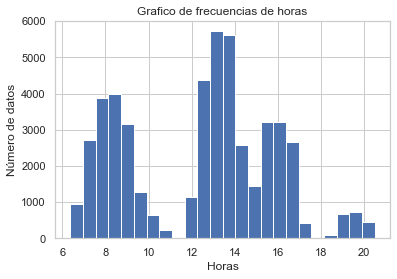

In [8]:
#Una vez obtenidos los datos se construye un histograma para visualizar el número de datos segun la hora definida
n_group = 24
#Definición del histograma
hist, bin_edges = np.histogram(velocidadest["hr"], n_group)
plt.hist(velocidadest["hr"], bins=bin_edges)
plt.xlabel("Horas")
plt.ylabel("Número de datos")
plt.title("Grafico de frecuencias de horas")
#plt.show()
plt.savefig("G:/Mi unidad/Docencia/Maestria UNAL/Trabajo de grado/Tesis 2.0/Tesis/Figuras/07HistFranjasTPC.png", dpi = 300)

In [9]:
#Obtener rangos pico y valle segun los definidos para la ciudad
velocidadest["pico_valle"] =0
for i in range(len(velocidadest)):
    if (velocidadest["hr"].iloc[i] >= 7.25) & (velocidadest["hr"].iloc[i] <= 8.25):
        velocidadest["pico_valle"].iloc[i] = "pico1"
    elif (velocidadest["hr"].iloc[i] >= 10.5) & (velocidadest["hr"].iloc[i] <= 11.5):
        velocidadest["pico_valle"].iloc[i] = "valle1"
    elif (velocidadest["hr"].iloc[i] >= 11.75) & (velocidadest["hr"].iloc[i] <= 12.75):
        velocidadest["pico_valle"].iloc[i] = "pico2"
    elif (velocidadest["hr"].iloc[i] >= 12.75) & (velocidadest["hr"].iloc[i] <= 13.75):
        velocidadest["pico_valle"].iloc[i] = "valle2"
    elif (velocidadest["hr"].iloc[i] >= 13.75) & (velocidadest["hr"].iloc[i] <= 14.75):
        velocidadest["pico_valle"].iloc[i] = "pico3"
    elif (velocidadest["hr"].iloc[i] >= 15.25) & (velocidadest["hr"].iloc[i] <= 16.25):
        velocidadest["pico_valle"].iloc[i] = "valle3"
    elif (velocidadest["hr"].iloc[i] >= 17.75) & (velocidadest["hr"].iloc[i] <= 18.75):
        velocidadest["pico_valle"].iloc[i] = "pico4"
    elif (velocidadest["hr"].iloc[i] >= 19.75) & (velocidadest["hr"].iloc[i] <= 20.45):
        velocidadest["pico_valle"].iloc[i] = "valle4"

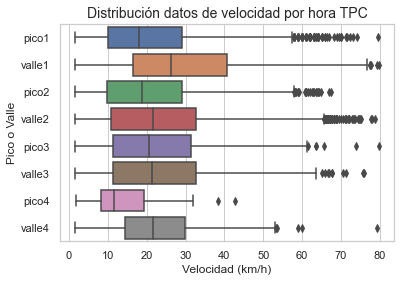

In [11]:
#Se realiza el boxplot de las velocidadest en carro de la RED teniendo en cuenta la franja horaria de estas
boxplot = sns.boxplot(y=velocidadest["pico_valle"], x=velocidadest["velocity_k"],
                      order=["pico1", "valle1", "pico2", "valle2", "pico3", "valle3", "pico4", "valle4"])
boxplot.axes.set_title("Distribución datos de velocidad por hora TPC", fontsize=14)
boxplot.set_xlabel("Velocidad (km/h)", fontsize=12)
boxplot.set_ylabel("Pico o Valle", fontsize=12)
#plt.show()
plt.savefig("G:/Mi unidad/Docencia/Maestria UNAL/Trabajo de grado/Tesis 2.0/Tesis/Articulo/Graficas/boxplot/TPC6.png", dpi = 300)

In [11]:
#Se guarda el shape en la ubicación deseada
#velocidades.to_file("C:/Users/user/Desktop/Tesis/VelocidadesPMMEP/picovalle/carro_pv1.shp")
velocidadest.to_file("G:/Mi unidad/Docencia/Maestria UNAL/Trabajo de grado/Tesis 2.0/Tesis/VelocidadesPMMEP/franjas/TPC.shp")

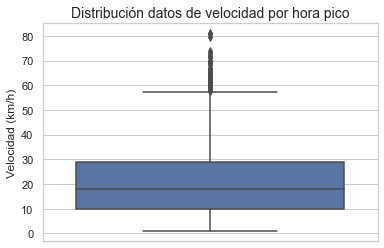

In [13]:
#se separa un gdf por hora para hacer la limpieza de outliners
pico1tpc = velocidadest[(velocidadest.pico_valle == "pico1")]
boxplot = sns.boxplot(y=pico1tpc["velocity_k"])
boxplot.axes.set_title("Distribución datos de velocidad por hora pico", fontsize=14)
boxplot.set_ylabel("Velocidad (km/h)", fontsize=12)
plt.show()

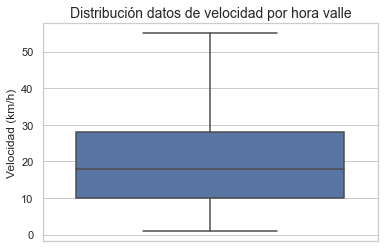

In [50]:
#se separa un gdf por hora para hacer la limpieza de outliners
pico1tpc = pico1tpc[(pico1tpc.velocity_k <= 55)]
boxplot = sns.boxplot(y=pico1tpc["velocity_k"])
boxplot.axes.set_title("Distribución datos de velocidad por hora valle", fontsize=14)
boxplot.set_ylabel("Velocidad (km/h)", fontsize=12)
plt.show()

In [51]:
pico1tpc.to_file("G:/Mi unidad/Docencia/Maestria UNAL/Trabajo de grado/Tesis 2.0/Tesis/VelocidadesPMMEP/comparacion/TPC/Pico1.shp")

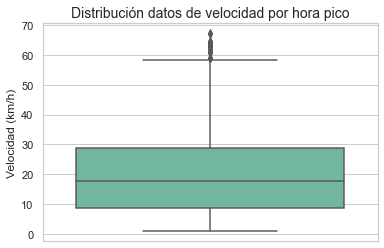

In [17]:
#se separa un gdf por hora para hacer la limpieza de outliners
pico2tpc = velocidadest[(velocidadest.pico_valle == "pico2")]
boxplot = sns.boxplot(y=pico2tpc["velocity_k"], palette="Set2")
boxplot.axes.set_title("Distribución datos de velocidad por hora pico", fontsize=14)
boxplot.set_ylabel("Velocidad (km/h)", fontsize=12)
plt.show()

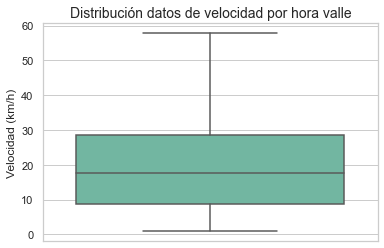

In [54]:
#se separa un gdf por hora para hacer la limpieza de outliners
pico2tpc = pico2tpc[(pico2tpc.velocity_k <= 58)]
boxplot = sns.boxplot(y=pico2tpc["velocity_k"], palette="Set2")
boxplot.axes.set_title("Distribución datos de velocidad por hora valle", fontsize=14)
boxplot.set_ylabel("Velocidad (km/h)", fontsize=12)
plt.show()

In [55]:
pico2tpc.to_file("G:/Mi unidad/Docencia/Maestria UNAL/Trabajo de grado/Tesis 2.0/Tesis/VelocidadesPMMEP/comparacion/TPC/Pico2.shp")

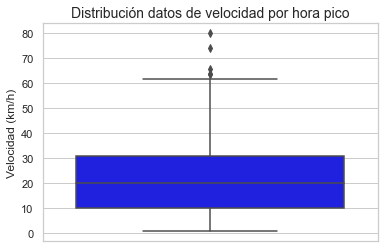

In [63]:
#se separa un gdf por hora para hacer la limpieza de outliners
pico3tpc = velocidadest[(velocidadest.pico_valle == "pico3")]
boxplot = sns.boxplot(y=pico3tpc["velocity_k"], color='blue')
boxplot.axes.set_title("Distribución datos de velocidad por hora pico", fontsize=14)
boxplot.set_ylabel("Velocidad (km/h)", fontsize=12)
plt.show()

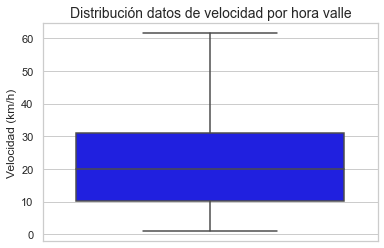

In [69]:
#se separa un gdf por hora para hacer la limpieza de outliners
pico3tpc = pico3tpc[(pico3tpc.velocity_k <= 63)]
boxplot = sns.boxplot(y=pico3tpc["velocity_k"], color='blue')
boxplot.axes.set_title("Distribución datos de velocidad por hora valle", fontsize=14)
boxplot.set_ylabel("Velocidad (km/h)", fontsize=12)
plt.show()

In [70]:
pico3tpc.to_file("G:/Mi unidad/Docencia/Maestria UNAL/Trabajo de grado/Tesis 2.0/Tesis/VelocidadesPMMEP/comparacion/TPC/Pico3.shp")

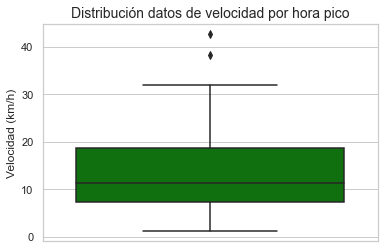

In [23]:
#se separa un gdf por hora para hacer la limpieza de outliners
pico4tpc = velocidadest[(velocidadest.pico_valle == "pico4")]
boxplot = sns.boxplot(y=pico4tpc["velocity_k"], color='green')
boxplot.axes.set_title("Distribución datos de velocidad por hora pico", fontsize=14)
boxplot.set_ylabel("Velocidad (km/h)", fontsize=12)
plt.show()

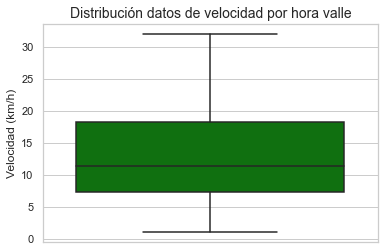

In [71]:
#se separa un gdf por hora para hacer la limpieza de outliners
pico4tpc = pico4tpc[(pico4tpc.velocity_k <= 35)]
boxplot = sns.boxplot(y=pico4tpc["velocity_k"], color='green')
boxplot.axes.set_title("Distribución datos de velocidad por hora valle", fontsize=14)
boxplot.set_ylabel("Velocidad (km/h)", fontsize=12)
plt.show()

In [72]:
pico4tpc.to_file("G:/Mi unidad/Docencia/Maestria UNAL/Trabajo de grado/Tesis 2.0/Tesis/VelocidadesPMMEP/comparacion/TPC/Pico4.shp")

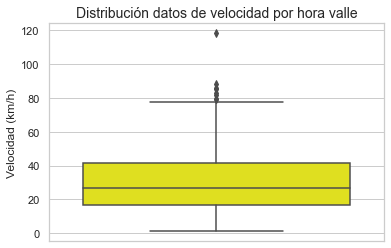

In [26]:
#se separa un gdf por hora para hacer la limpieza de outliners
valle1tpc = velocidadest[(velocidadest.pico_valle == "valle1")]
boxplot = sns.boxplot(y=valle1tpc["velocity_k"], color='yellow')
boxplot.axes.set_title("Distribución datos de velocidad por hora valle", fontsize=14)
boxplot.set_ylabel("Velocidad (km/h)", fontsize=12)
plt.show()

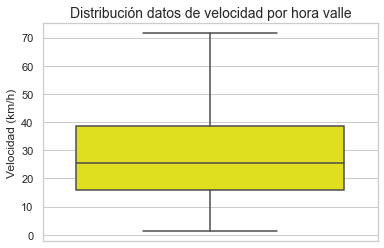

In [78]:
#se separa un gdf por hora para hacer la limpieza de outliners
valle1tpc = valle1tpc[(valle1tpc.velocity_k <= 74)]
boxplot = sns.boxplot(y=valle1tpc["velocity_k"], color='yellow')
boxplot.axes.set_title("Distribución datos de velocidad por hora valle", fontsize=14)
boxplot.set_ylabel("Velocidad (km/h)", fontsize=12)
plt.show()

In [79]:
valle1tpc.to_file("G:/Mi unidad/Docencia/Maestria UNAL/Trabajo de grado/Tesis 2.0/Tesis/VelocidadesPMMEP/comparacion/TPC/Valle1.shp")

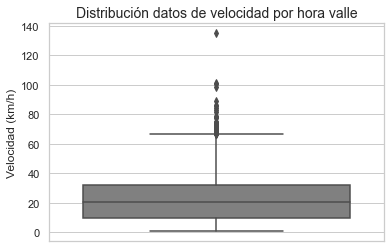

In [29]:
#se separa un gdf por hora para hacer la limpieza de outliners
valle2tpc = velocidadest[(velocidadest.pico_valle == "valle2")]
boxplot = sns.boxplot(y=valle2tpc["velocity_k"], color='gray')
boxplot.axes.set_title("Distribución datos de velocidad por hora valle", fontsize=14)
boxplot.set_ylabel("Velocidad (km/h)", fontsize=12)
plt.show()

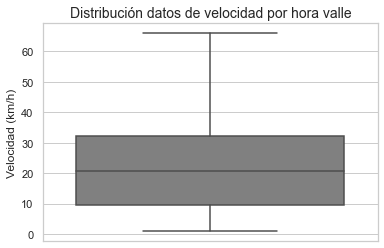

In [83]:
#se separa un gdf por hora para hacer la limpieza de outliners
valle2tpc = valle2tpc[(valle2tpc.velocity_k <= 66)]
boxplot = sns.boxplot(y=valle2tpc["velocity_k"], color='gray')
boxplot.axes.set_title("Distribución datos de velocidad por hora valle", fontsize=14)
boxplot.set_ylabel("Velocidad (km/h)", fontsize=12)
plt.show()

In [84]:
valle2tpc.to_file("G:/Mi unidad/Docencia/Maestria UNAL/Trabajo de grado/Tesis 2.0/Tesis/VelocidadesPMMEP/comparacion/TPC/Valle2.shp")

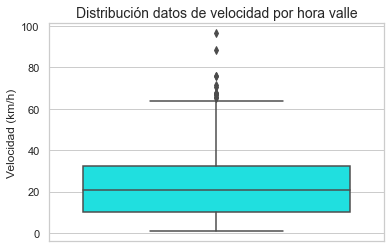

In [88]:
#se separa un gdf por hora para hacer la limpieza de outliners
valle3tpc = velocidadest[(velocidadest.pico_valle == "valle3")]
boxplot = sns.boxplot(y=valle3tpc["velocity_k"], color='cyan')
boxplot.axes.set_title("Distribución datos de velocidad por hora valle", fontsize=14)
boxplot.set_ylabel("Velocidad (km/h)", fontsize=12)
plt.show()

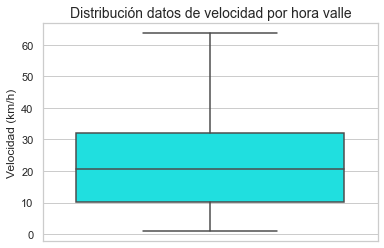

In [90]:
#se separa un gdf por hora para hacer la limpieza de outliners
valle3tpc = valle3tpc[(valle3tpc.velocity_k <= 65)]
boxplot = sns.boxplot(y=valle3tpc["velocity_k"], color='cyan')
boxplot.axes.set_title("Distribución datos de velocidad por hora valle", fontsize=14)
boxplot.set_ylabel("Velocidad (km/h)", fontsize=12)
plt.show()

In [91]:
valle3tpc.to_file("G:/Mi unidad/Docencia/Maestria UNAL/Trabajo de grado/Tesis 2.0/Tesis/VelocidadesPMMEP/comparacion/TPC/Valle3.shp")

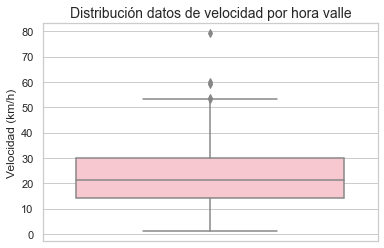

In [35]:
#se separa un gdf por hora para hacer la limpieza de outliners
valle4tpc = velocidadest[(velocidadest.pico_valle == "valle4")]
boxplot = sns.boxplot(y=valle4tpc["velocity_k"], color='pink')
boxplot.axes.set_title("Distribución datos de velocidad por hora valle", fontsize=14)
boxplot.set_ylabel("Velocidad (km/h)", fontsize=12)
plt.show()

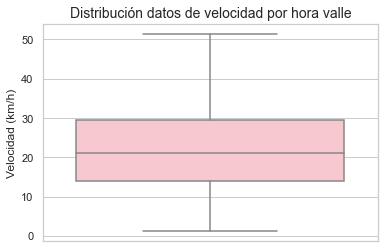

In [95]:
#se separa un gdf por hora para hacer la limpieza de outliners
valle4tpc = valle4tpc[(valle4tpc.velocity_k <= 53)]
boxplot = sns.boxplot(y=valle4tpc["velocity_k"], color='pink')
boxplot.axes.set_title("Distribución datos de velocidad por hora valle", fontsize=14)
boxplot.set_ylabel("Velocidad (km/h)", fontsize=12)
plt.show()

In [96]:
valle4tpc.to_file("G:/Mi unidad/Docencia/Maestria UNAL/Trabajo de grado/Tesis 2.0/Tesis/VelocidadesPMMEP/comparacion/TPC/Valle4.shp")

Continua en el codigo Asignacion_por_horario.ipynb donde se distinguiran las velocidades segun el horario a la red vial